In [1]:
import json
import pandas as pd
import altair as alt
from datetime import datetime, timedelta

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
df = pd.read_csv("./_data/sales.csv")

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
def percentage_change(old_value, new_value, multiply=True, fail_silently=True):
    """
    Accepts two integers, an old and a new number,
    and then measures the percent change between them.
    The change between the two numbers is determined
    and then divided into the original figure.
    By default, it is then multiplied by 100, and
    returning as a float.
    If you don't want the number multiplied by 100,
    set the 'multiply' kwarg to False.
    If you divide into zero -- an illegal operation -- a null value
    is returned by default. If you prefer for an error to be raised,
    set the kwarg 'fail_silently' to False.
    h3. Example usage
        >> import calculate
        >> calculate.percentage_change(2, 10)
        400.0
    h3. Documentation
        * "percentage_change":http://en.wikipedia.org/wiki/Percentage_change
    """
    change = new_value - old_value
    try:
        percentage_change = (change / float(old_value))
        if multiply:
            percentage_change = percentage_change * 100
        return percentage_change
    except ZeroDivisionError:
        # If there's a zero involved return null if set to fail silent
        if fail_silently:
            return None
        # but otherwise shout it all out
        else:
            raise ZeroDivisionError("Sorry. You can't divide into zero.")

## Promenade West

In [6]:
pwest = df[df.building_name == 'Promenade West']
pwest.to_csv("./_data/pwest_sales.csv", index=False)

In [7]:
def year_over_year_comparison(df):
    this_year = df[df.year == datetime.now().year]
    last_year = df[df.year == datetime.now().year - 1]
    stats = {
        'this_year': {
            'count': len(this_year),
            'median_price': this_year.price.median(),
            'median_price_per_sqft': this_year.price_per_square_foot.median(),
        },
        'last_year': {
            'count': len(last_year),
            'median_price': last_year.price.median(),
            'median_price_per_sqft': last_year.price_per_square_foot.median(),
        },
        'all_time': {
            'median_sqft': df.square_feet.median()
        }
    }
    stats.update({
        'change': {
            'price': percentage_change(stats['last_year']['median_price'], stats['this_year']['median_price']), 
            'median_price_per_sqft': percentage_change(stats['last_year']['median_price_per_sqft'], stats['this_year']['median_price_per_sqft']), 
        }
    })
    return stats

In [8]:
json.dump(year_over_year_comparison(pwest), open("./_data/pwest.json", "w"), indent=4)

### Most recent sales

In [9]:
pwest.sort_values("date", ascending=False)[[
    'building_name',
    'date',
    'unit',
    'price',
    'square_feet',
    'price_per_square_foot'
]].head(5)

,building_name,date,unit,price,square_feet,price_per_square_foot
1992,Promenade West,2018-07-03,308,620000.0,1323.0,468.631897
1993,Promenade West,2018-06-12,527,600000.0,1323.0,453.514739
1994,Promenade West,2018-04-11,706,598000.0,1348.0,443.620178
1995,Promenade West,2018-02-01,409,590000.0,1323.0,445.956160
1996,Promenade West,2018-01-24,315,615000.0,1509.0,407.554672


### The pace of sales

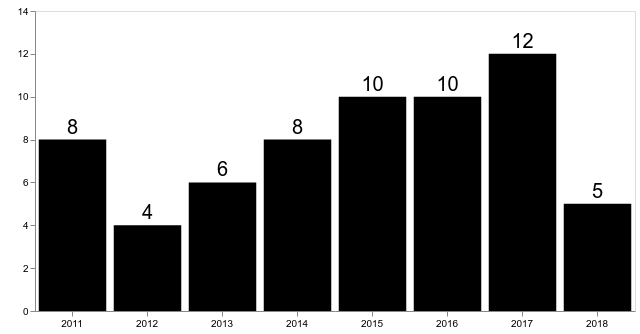

In [10]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 14)), axis=alt.Axis(title="", grid=False))
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(
    text='count()'
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/sales-by-year.svg')

chart

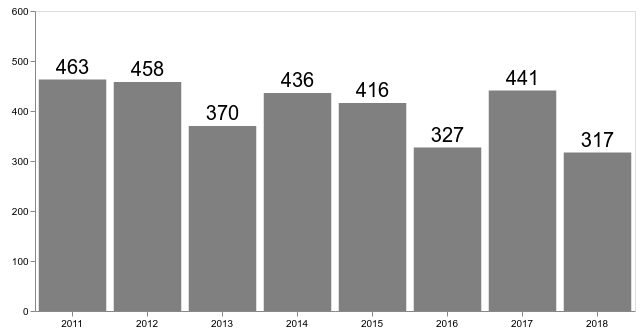

In [11]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 600)), axis=alt.Axis(title="", grid=False))
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(
    text='count()'
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/dtla-sales-by-year.svg')

chart

### Prices by date

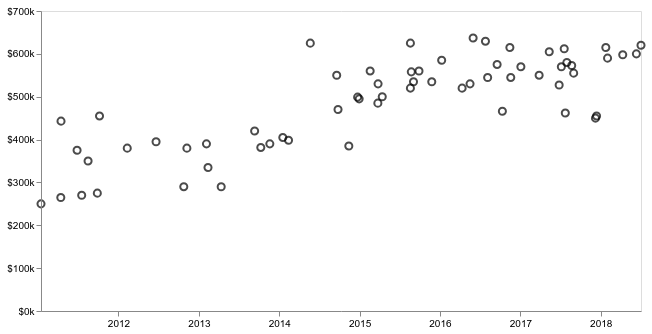

In [12]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 700000])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

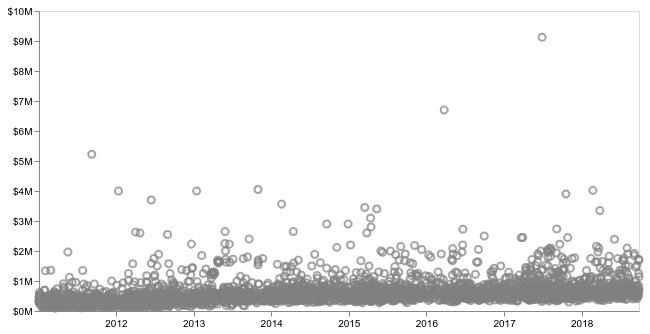

In [13]:
chart = alt.Chart(df).mark_point(size=50, color="gray").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 10000000])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/dtla-price-by-date.svg')

chart

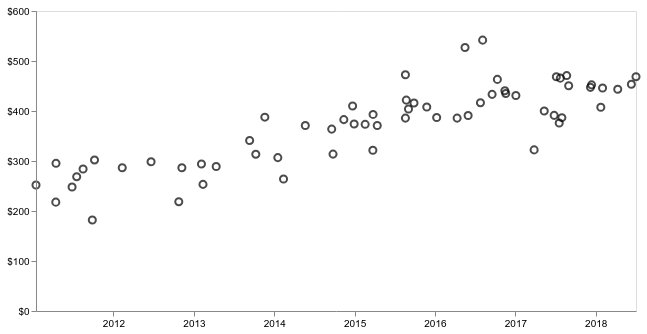

In [14]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 600])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-per-sqft-by-date.svg')

chart

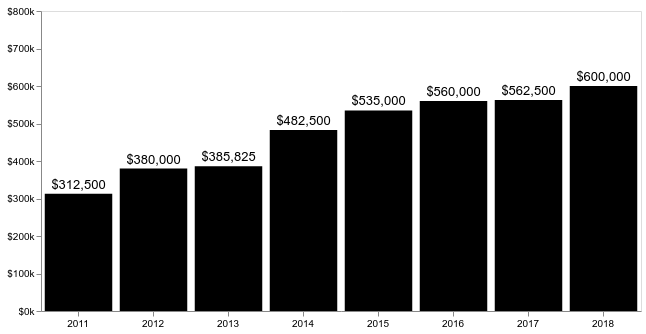

In [15]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

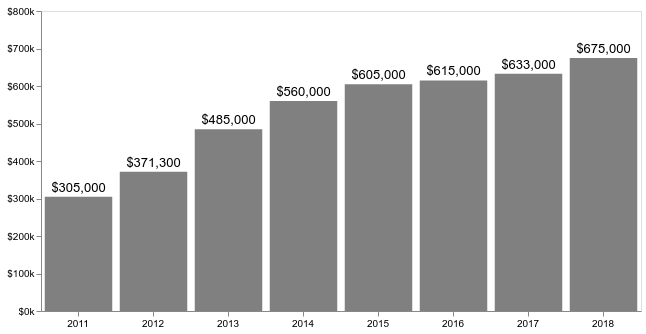

In [16]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/dtla-price-by-year.svg')

chart

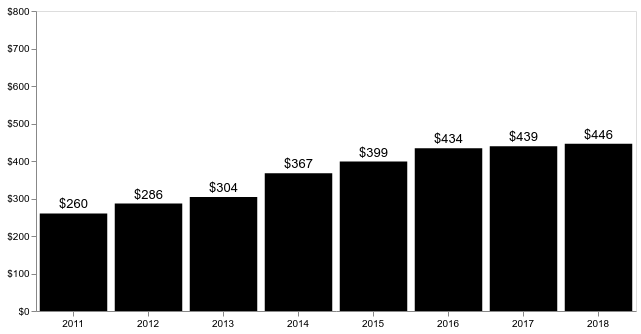

In [17]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-per-sqft-by-year.svg')

chart

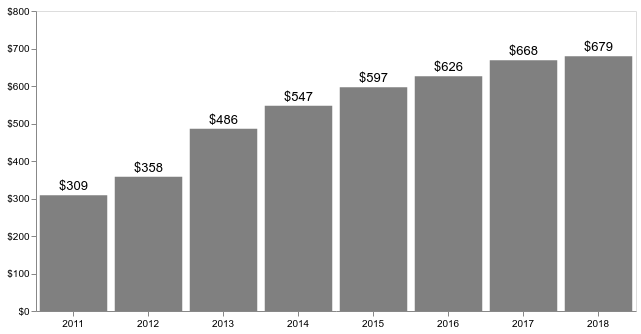

In [18]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = bars + text

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/dtla-price-per-sqft-by-year.svg')

chart

## Bunker Hill

In [19]:
bunker_hill = df[df.region == 'Bunker Hill']

In [20]:
bunker_hill.groupby(["building_name", "year"]).price.median().unstack(1).reset_index().to_csv("./_data/bunker_hill_prices.csv", index=False)

In [21]:
bunker_hill.groupby(["building_name", "year"]).price_per_square_foot.median().unstack(1).reset_index().to_csv("./_data/bunker_hill_price_per_sqft.csv", index=False)

In [22]:
bunker_hill.groupby(["building_name", "year"]).size().rename("sale").unstack(1).reset_index().to_csv("./_data/bunker_hill_sales.csv", index=False)

In [23]:
json.dump(year_over_year_comparison(bunker_hill), open("./_data/bunkerhill.json", "w"), indent=4)

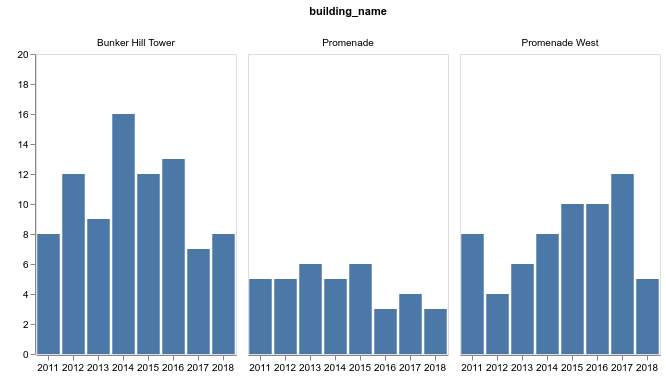

In [24]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 20)), axis=alt.Axis(title="", grid=False)),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/sales-by-year.svg')

chart

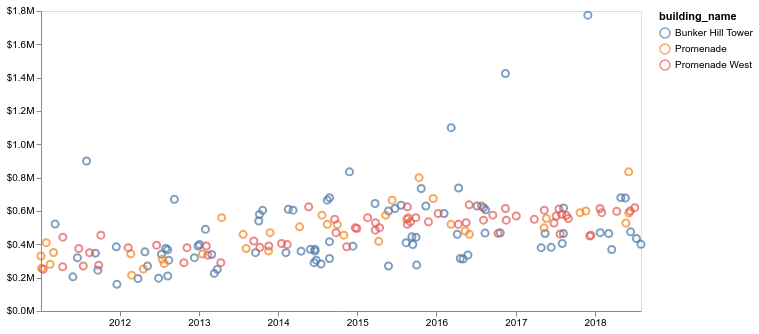

In [25]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="building_name",
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

In [26]:
bunker_hill.head()

,bathrooms,bedrooms,building_name,building_number,date,price,region,square_feet,unit,url,price_per_square_foot,year
594,1.0,0.0,Bunker Hill Tower,14,2018-08-01,400000.0,Bunker Hill,481.0,1409,https://www.dlxco.com/the-promenade-west-lofts...,831.600832,2018
595,1.0,0.0,Bunker Hill Tower,14,2018-07-11,435000.0,Bunker Hill,481.0,1304,https://www.dlxco.com/the-promenade-west-lofts...,904.365904,2018
596,1.0,1.0,Bunker Hill Tower,14,2018-06-14,475000.0,Bunker Hill,762.0,1702,https://www.dlxco.com/the-promenade-west-lofts...,623.359580,2018
597,2.0,2.0,Bunker Hill Tower,14,2018-05-21,678000.0,Bunker Hill,1234.0,1610,https://www.dlxco.com/the-promenade-west-lofts...,549.432739,2018
598,2.0,2.0,Bunker Hill Tower,14,2018-04-30,680000.0,Bunker Hill,1234.0,1203,https://www.dlxco.com/the-promenade-west-lofts...,551.053485,2018


In [28]:
# pd.merge(
#     bunker_hill.groupby(["building_name", 'year']).price.median().reset_index(),
#     bunker_hill.groupby(["building_name", 'year']).price_per_square_foot.median().reset_index()
# ).pivot(index="year")

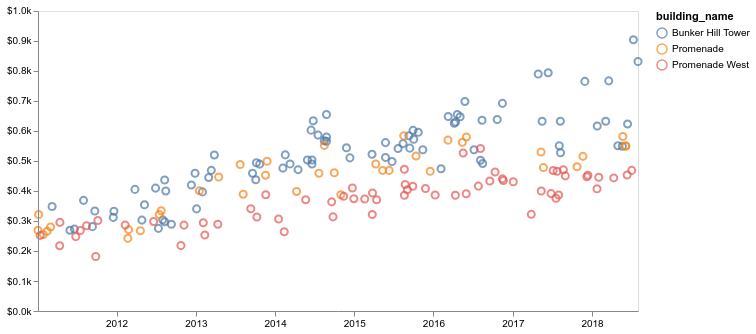

In [29]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False)
    ),
    color="building_name:N",
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-per-sqft-by-date.svg')

chart

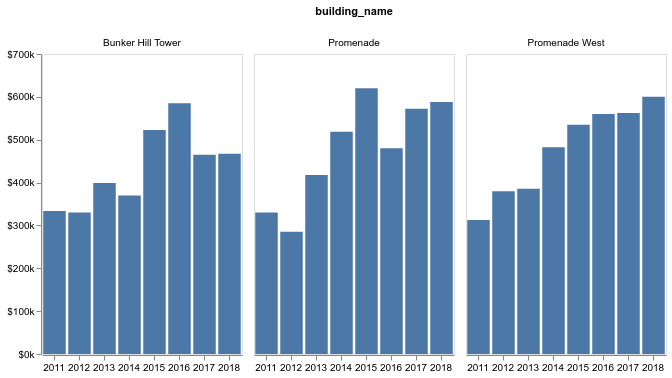

In [30]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 700000]),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

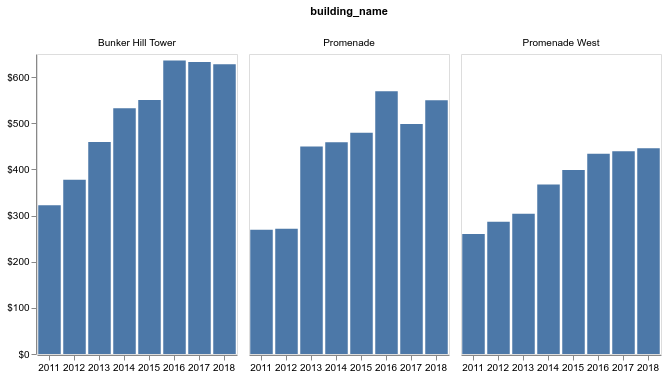

In [31]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

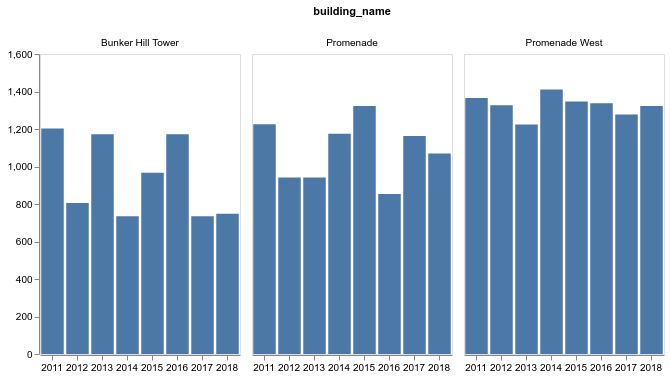

In [32]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(square_feet):Q",
        axis=alt.Axis(title="", grid=False),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

## Region

In [33]:
json.dump(year_over_year_comparison(df), open("./_data/dtla.json", "w"), indent=4)

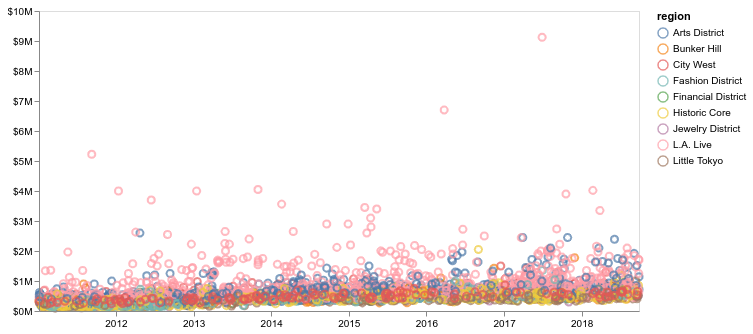

In [34]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

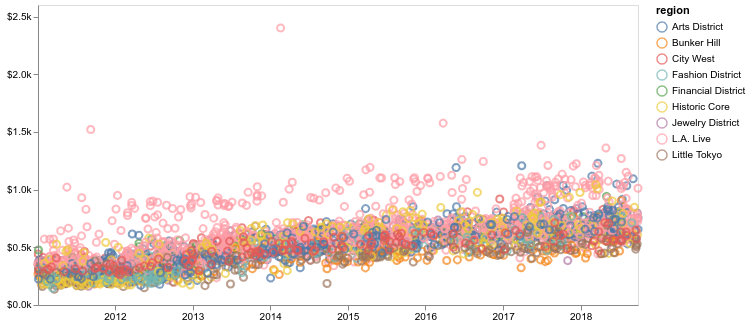

In [35]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

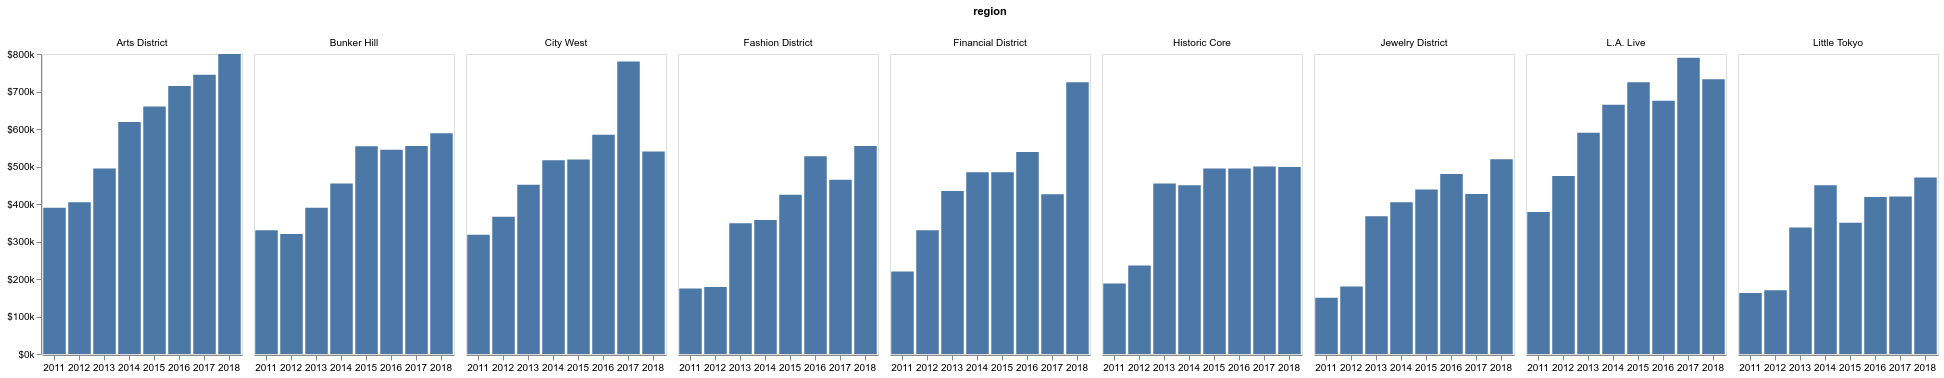

In [36]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="region:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

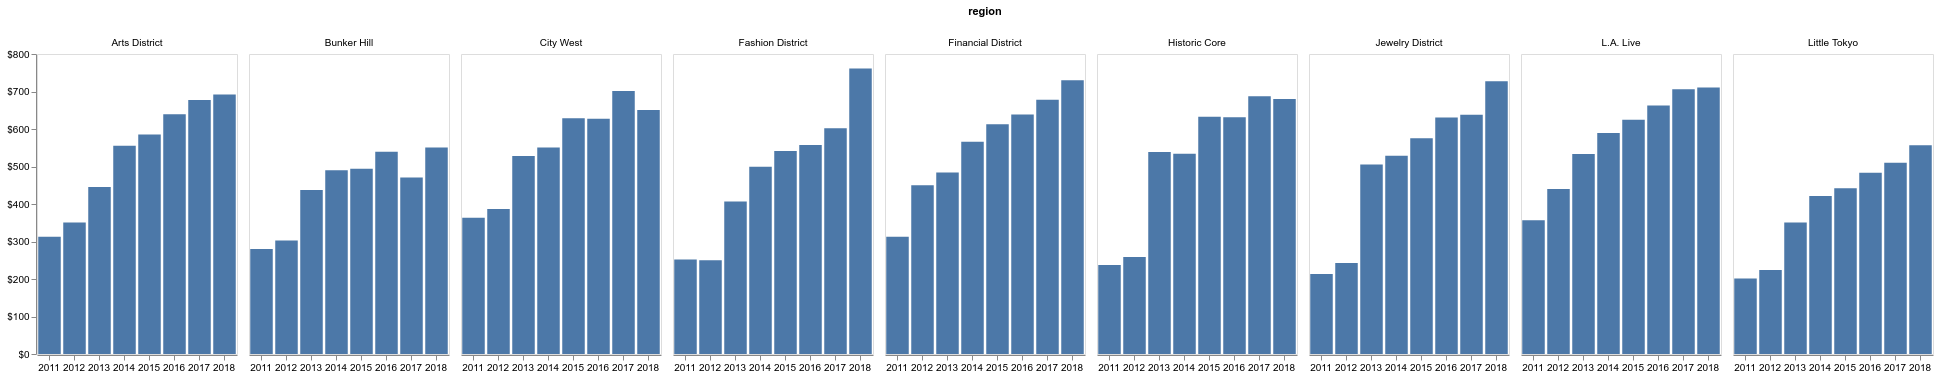

In [37]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="region:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

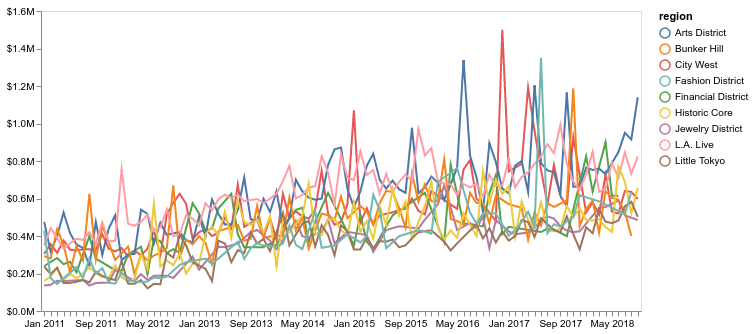

In [38]:
chart = alt.Chart(df).mark_line().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region:N"
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

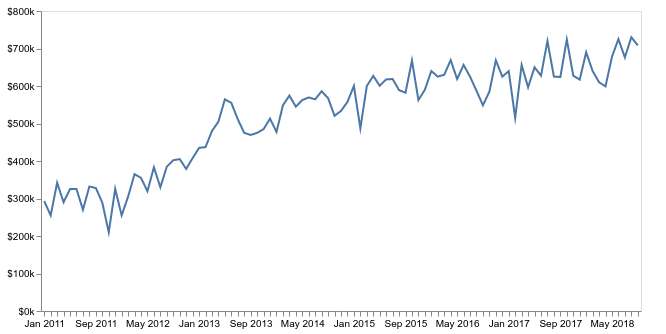

In [39]:
chart = alt.Chart(df).mark_line().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

## Rankings

In [40]:
building_ranking = df.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
})

In [41]:
building_ranking.sort_values("price_per_square_foot", ascending=False)

,,unit,price,price_per_square_foot,square_feet
building_name,region,,,,
Metropolis Tower II,L.A. Live,1,900000.0,1269.393512,709.0
Metropolis Tower I,L.A. Live,18,973000.0,1098.527822,977.0
Ritz Carlton,L.A. Live,101,1755000.0,977.917981,1840.0
Ten50,L.A. Live,54,996500.0,926.879571,1114.0
The Rowan,Historic Core,98,509950.0,674.652778,823.5
Luma Lofts,L.A. Live,156,625000.0,655.883913,990.0
Concerto Lofts,L.A. Live,22,635000.0,636.906918,997.5
Douglas,Historic Core,32,465500.0,630.249480,950.0
Biscuit Company Lofts,Arts District,64,732500.0,629.258309,1112.0


In [42]:
region_ranking = df.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
})

In [43]:
region_ranking.sort_values("price_per_square_foot", ascending=False)

,unit,price,price_per_square_foot,square_feet
region,,,,
L.A. Live,1152,644500.0,610.589701,1170.0
City West,258,500000.0,545.999171,940.0
Historic Core,363,425000.0,542.112676,820.0
Financial District,103,410000.0,534.804754,740.0
Arts District,682,586000.0,525.105321,1174.0
Jewelry District,93,399000.0,525.000000,740.0
Bunker Hill,185,465000.0,452.286282,1172.0
Fashion District,148,357000.0,451.153324,795.0
Little Tokyo,244,363000.0,431.340189,863.0


## Last 12 months

In [44]:
one_year_ago = datetime.now() - timedelta(days=365)

In [45]:
last_year = df[df.date > one_year_ago]

In [46]:
last_year.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,,unit,price,price_per_square_foot,square_feet
building_name,region,,,,
Metropolis Tower II,L.A. Live,1,900000.0,1269.393512,709.0
Metropolis Tower I,L.A. Live,8,723500.0,1132.925149,657.0
Ritz Carlton,L.A. Live,14,1724500.0,1063.519220,1680.0
Ten50,L.A. Live,19,1099000.0,1000.000000,1144.0
Biscuit Company Lofts,Arts District,13,860000.0,995.482927,1112.0
The Rowan,Historic Core,10,630000.0,874.591503,720.0
Gallery Lofts,Arts District,4,743000.0,819.232250,901.0
Barker Block Warehouse,Arts District,5,785000.0,792.134831,1070.0
Santee Village: Cornell,Fashion District,3,499000.0,767.692308,650.0


In [47]:
df.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,unit,price,price_per_square_foot,square_feet
region,,,,
L.A. Live,1152,644500.0,610.589701,1170.0
City West,258,500000.0,545.999171,940.0
Historic Core,363,425000.0,542.112676,820.0
Financial District,103,410000.0,534.804754,740.0
Arts District,682,586000.0,525.105321,1174.0
Jewelry District,93,399000.0,525.000000,740.0
Bunker Hill,185,465000.0,452.286282,1172.0
Fashion District,148,357000.0,451.153324,795.0
Little Tokyo,244,363000.0,431.340189,863.0


## Largest units

In [48]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "median(square_feet):Q",
        axis=alt.Axis(title="")
    ),
    y=alt.Y(
        "building_name:N",
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="square_feet", op="median", order="descending")
    ),
    color=alt.condition(
        alt.datum.building_name == 'Promenade West',
        alt.value("black"),
        alt.value("gray")
    )
)

chart.configure_view(
    strokeOpacity=0
).save('assets/size-by-building.svg')

chart

SchemaValidationError: Invalid specification

        altair.vegalite.v2.schema.core.SortField, validating 'additionalProperties'

        Additional properties are not allowed ('op' was unexpected)
        